In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, average_precision_score, classification_report
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [100]:
df = pd.read_csv("../../data/mean_with_labels.csv")

In [101]:
print(df.head(5))

   transcript_name  json_position nucleotide_seq  dwelling_time_min1  \
0  ENST00000361789              3        ATGACCC            0.008473   
1  ENST00000362079              3        ATGACCC            0.005891   
2  ENST00000330439              4        CTGACTG            0.005284   
3  ENST00000380455              5        GGAACCT            0.006620   
4  ENST00000387347              5        TAAACCT            0.007985   

    sd_min1   mean_min1  dwelling_time        sd        mean  \
0  4.156000   98.027500       0.008403  9.436250  117.550000   
1  4.074295   98.133333       0.006638  9.287051  118.069231   
2  3.684516  111.146774       0.007605  7.364839  121.612903   
3  8.528696  120.826087       0.010325  3.845217   94.739130   
4  2.421880  104.497000       0.007066  4.059900   98.490000   

   dwelling_time_plus1  sd_plus1  mean_plus1  dwelling_time_merged  sd_merged  \
0             0.005935  3.180750   79.072500              0.007603   5.591000   
1             0.0066

In [102]:
# remove transcript_name, gene_id and nucleotide_seq for now
df1 = df.drop(["transcript_name", "gene_id", "nucleotide_seq"], axis=1)

In [103]:
# number of unique nucleotide sequences
df["nucleotide_seq"].unique().shape[0]

288

### Evaluation function

In [104]:
def evaluate_model(y_true, y_pred, y_pred_proba, model_name="Model"):
    """
    Evaluate a model using classification report and precision-recall curve.
    
    Parameters:
    y_true (array-like): True labels
    y_pred (array-like): Predicted labels
    y_pred_proba (array-like): Predicted probabilities for the positive class
    model_name (str): Name of the model for plot title
    
    Returns:
    dict: A dictionary containing the classification report and average precision score
    """
    # Classification Report
    class_report = classification_report(y_true, y_pred, target_names=['no m6a modification', 'm6a modification'], output_dict=True)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['no m6a modification', 'm6a modification']))
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    average_precision = average_precision_score(y_true, y_pred_proba)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, color='b', label=f'AP = {average_precision:.2f}')
    plt.axhline(y=np.sum(y_true)/len(y_true), color='r', linestyle='--', label='No Skill')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ({model_name})')
    plt.legend()
    plt.show()
    
    print(f"\nAverage Precision Score: {average_precision:.3f}")
    
    return {
        "classification_report": class_report,
        "average_precision": average_precision
    }

## Resampling methods
- Stratification (equal ratio of positive and negative labels)
- Undersampling
- Oversampling

In [105]:
# stratification
X = df1.drop('label', axis=1)
y = df1['label']

### Stratification

In [106]:
# First, perform train-test split to keep test set intact
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("\nAfter train-test split:")
print("Training set shape:", X_train.shape)
print("Training label distribution:\n", y_train.value_counts())
print("Test set shape:", X_test.shape)
print("Test label distribution:\n", y_test.value_counts())

# Now, apply undersampling to the training set only
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train, y_train)

print("\nAfter undersampling the training set:")
print("Balanced training set shape:", X_train_balanced.shape)
print("Balanced training label distribution:\n", pd.Series(y_train_balanced).value_counts())
print("Test set shape (unchanged):", X_test.shape)
print("Test label distribution (unchanged):\n", y_test.value_counts())

# Calculate and print percentages
train_total = len(y_train_balanced)
test_total = len(y_test)

print("\nBalanced training set percentages:")
for label, count in pd.Series(y_train_balanced).value_counts().items():
    percentage = (count / train_total) * 100
    print(f"Label {label}: {percentage:.2f}%")

print("\nTest set percentages (original distribution):")
for label, count in y_test.value_counts().items():
    percentage = (count / test_total) * 100
    print(f"Label {label}: {percentage:.2f}%")



After train-test split:
Training set shape: (97470, 13)
Training label distribution:
 label
0    93090
1     4380
Name: count, dtype: int64
Test set shape: (24368, 13)
Test label distribution:
 label
0    23273
1     1095
Name: count, dtype: int64

After undersampling the training set:
Balanced training set shape: (8760, 13)
Balanced training label distribution:
 label
0    4380
1    4380
Name: count, dtype: int64
Test set shape (unchanged): (24368, 13)
Test label distribution (unchanged):
 label
0    23273
1     1095
Name: count, dtype: int64

Balanced training set percentages:
Label 0: 50.00%
Label 1: 50.00%

Test set percentages (original distribution):
Label 0: 95.51%
Label 1: 4.49%


In [107]:
# scale all numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

In [108]:
print(X_train_balanced.shape)
print(y_train_balanced.shape)

print(X_test.shape)
print(y_test.shape)

(8760, 13)
(8760,)
(24368, 13)
(24368,)


In [109]:
# logistic regression model
logreg = LogisticRegression()

# fit model with data, selected following variables: "transcript_position", "dwelling_time_merged", "sd_merged", "mean_merged"
logreg.fit(X_train_balanced.loc[:, ["json_position", "dwelling_time_merged", "sd_merged", "mean_merged"]], y_train_balanced)

y_pred = logreg.predict(X_test.loc[:, ["json_position", "dwelling_time_merged", "sd_merged", "mean_merged"]])
y_pred_prob = logreg.predict_proba(X_test.loc[:, ["json_position", "dwelling_time_merged", "sd_merged", "mean_merged"]]) #probability not prediction

In [110]:
print(y_pred_prob[0:2]) #shows prob of classes 0, 1 respectively

[[0.73588396 0.26411604]
 [0.76249903 0.23750097]]


In [111]:
#print(classification_report(y_test, y_pred))

target_names = ['no m6a modification', 'm6a modification'] # labels 0, 1
print(classification_report(y_test, y_pred, target_names=target_names))

                     precision    recall  f1-score   support

no m6a modification       0.97      0.60      0.75     23273
   m6a modification       0.07      0.66      0.13      1095

           accuracy                           0.61     24368
          macro avg       0.52      0.63      0.44     24368
       weighted avg       0.93      0.61      0.72     24368



<Figure size 1000x600 with 0 Axes>

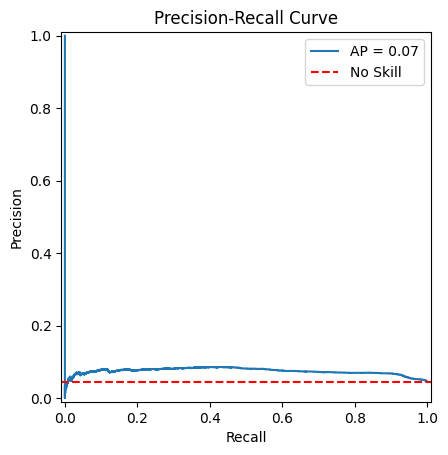

Average Precision Score: 0.074
Best threshold: 0.843
Best F1-Score: nan
Precision at best F1: 0.000
Recall at best F1: 0.000


C:\Users\User\AppData\Local\Temp\ipykernel_17828\3702128183.py:21: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [112]:
y_pred_proba = logreg.predict_proba(X_test.loc[:, ["json_position", "dwelling_time_merged", "sd_merged", "mean_merged"]])[:, 1]  # Probability of positive class

# PR curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# average precision
average_precision = average_precision_score(y_test, y_pred_proba)

# Plot the Precision-Recall curve
plt.figure(figsize=(10, 6))
display = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=average_precision)
display.plot()
plt.title('Precision-Recall Curve')
plt.axhline(y=sum(y_test)/len(y_test), color='r', linestyle='--', label='No Skill')
plt.legend()
plt.show()

print(f"Average Precision Score: {average_precision:.3f}")

# Find the threshold that gives the best F1 score
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]
best_f1 = f1_scores[best_threshold_index]

print(f"Best threshold: {best_threshold:.3f}")
print(f"Best F1-Score: {best_f1:.3f}")
print(f"Precision at best F1: {precision[best_threshold_index]:.3f}")
print(f"Recall at best F1: {recall[best_threshold_index]:.3f}")

### Oversampling techniques

Original training dataset shape: label
0    93090
1     4380
Name: count, dtype: int64
Resampled training dataset shape: label
0    93090
1    93090
Name: count, dtype: int64

Classification Report:
                     precision    recall  f1-score   support

no m6a modification       0.98      0.64      0.77     23273
   m6a modification       0.08      0.70      0.15      1095

           accuracy                           0.64     24368
          macro avg       0.53      0.67      0.46     24368
       weighted avg       0.94      0.64      0.74     24368



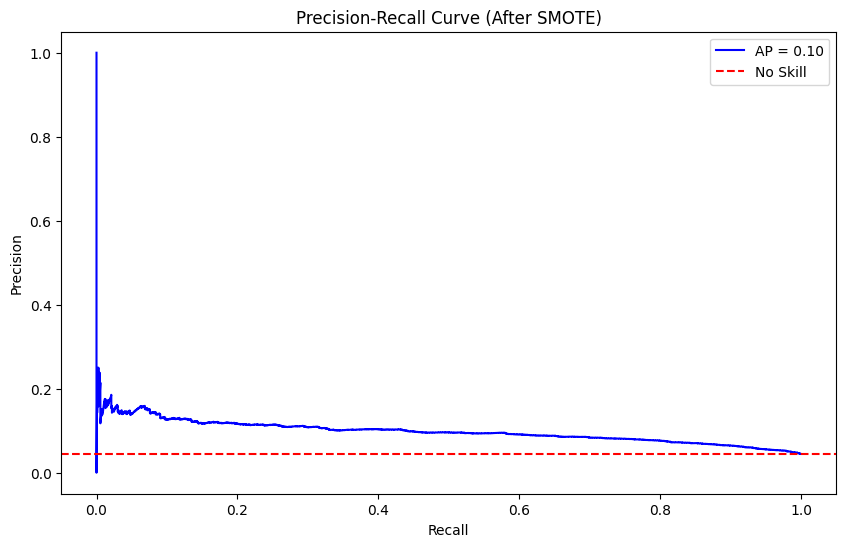


Average Precision Score: 0.098


In [113]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("Original training dataset shape:", y_train.value_counts())
print("Resampled training dataset shape:", pd.Series(y_train_resampled).value_counts())

# Train logistic regression on the resampled data
logreg_2 = LogisticRegression(random_state=42)
logreg_2.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred = logreg_2.predict(X_test_scaled)
y_pred_proba = logreg_2.predict_proba(X_test_scaled)[:, 1]

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['no m6a modification', 'm6a modification']))

# Generate Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)

# Plot Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='b', label=f'AP = {average_precision:.2f}')
plt.axhline(y=sum(y_test)/len(y_test), color='r', linestyle='--', label='No Skill')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (After SMOTE)')
plt.legend()
plt.show()

print(f"\nAverage Precision Score: {average_precision:.3f}")

### changing the choice of model (DT)

Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}

Classification Report:
                     precision    recall  f1-score   support

no m6a modification       0.99      0.80      0.89     23273
   m6a modification       0.15      0.75      0.25      1095

           accuracy                           0.80     24368
          macro avg       0.57      0.78      0.57     24368
       weighted avg       0.95      0.80      0.86     24368



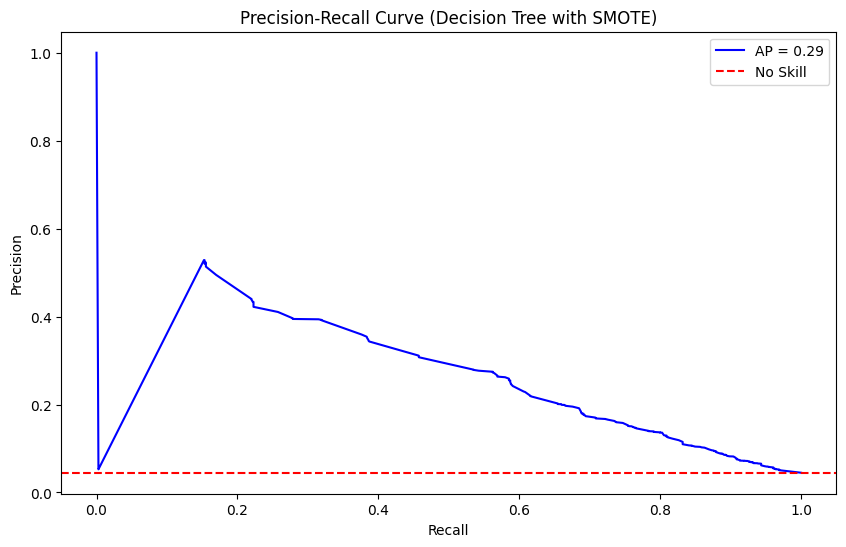


Average Precision Score: 0.287


In [114]:
dt_classifier = DecisionTreeClassifier(random_state=42)

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(dt_classifier, param_grid, cv=5, scoring='f1', n_jobs=4)
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_dt = grid_search.best_estimator_
print("Best hyperparameters:", grid_search.best_params_)

# Make predictions on the test set
y_pred = best_dt.predict(X_test_scaled)
y_pred_proba = best_dt.predict_proba(X_test_scaled)[:, 1]

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['no m6a modification', 'm6a modification']))

# Generate Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)

# Plot Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='b', label=f'AP = {average_precision:.2f}')
plt.axhline(y=sum(y_test)/len(y_test), color='r', linestyle='--', label='No Skill')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Decision Tree with SMOTE)')
plt.legend()
plt.show()

print(f"\nAverage Precision Score: {average_precision:.3f}")

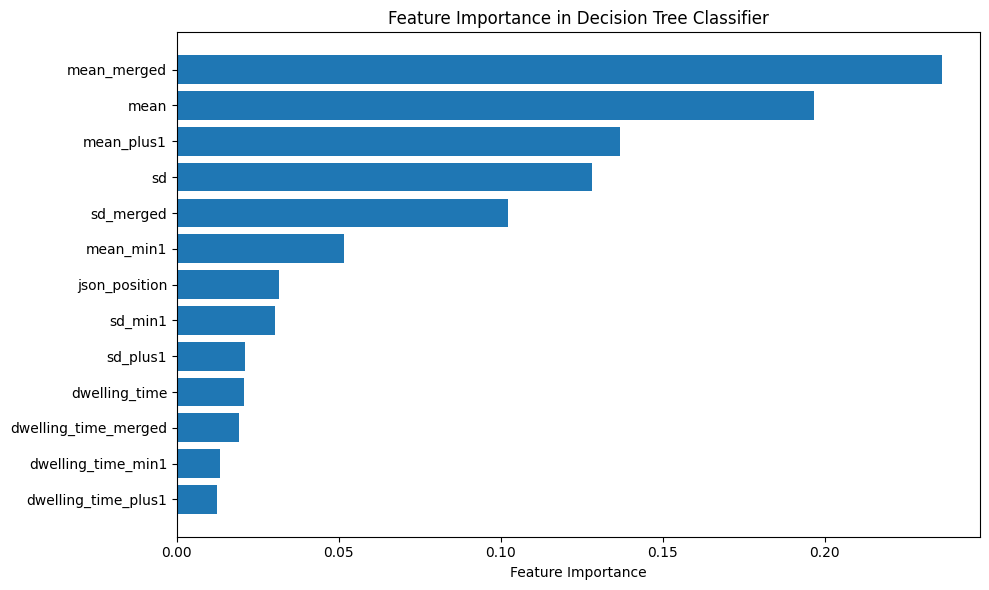

In [115]:
# Feature importance
feature_importance = best_dt.feature_importances_
feature_names = X.columns  # Assuming X is a DataFrame with column names

# Sort features by importance
sorted_idx = np.argsort(feature_importance)
sorted_features = feature_names[sorted_idx]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance[sorted_idx])
plt.yticks(range(len(feature_importance)), sorted_features)
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Decision Tree Classifier')
plt.tight_layout()
plt.show()

## stuff to work on
- using ensemble models, gradient boosting trees or NN
- test DT with undersampling
- remove some less important features

## (extra) feature engineering

In [116]:
# observe rows with labels = 1
df_positive = df[df["label"] == 1]

In [117]:
print(df_positive.head())

    transcript_name  json_position nucleotide_seq  dwelling_time_min1  \
19  ENST00000366839             12        GGGACTC            0.008896   
27  ENST00000373970             13        AGGACTC            0.008555   
56  ENST00000199706             19        TGAACCC            0.006113   
60  ENST00000543683             19        GGGACCC            0.009687   
76  ENST00000530797             22        GAGACTT            0.007183   

     sd_min1   mean_min1  dwelling_time        sd        mean  \
19  3.677143  119.714286       0.011609  5.577143  124.285714   
27  5.265855  117.751295       0.009486  4.918601  124.331606   
56  8.643333  120.375000       0.008742  3.878750   94.512500   
60  4.538487  118.230769       0.009055  8.238872  119.128205   
76  4.781054  122.362998       0.009455  5.363700  133.250585   

    dwelling_time_plus1  sd_plus1  mean_plus1  dwelling_time_merged  \
19             0.009530  3.568571   91.146429              0.010012   
27             0.006473  2.5

In [118]:
# # transcript_name, json_position, nucleotide_seq, dwelling_time_min1, sd_min1, mean_min1, dwelling_time, sd, mean,
# # dwelling_time_plus1, sd_plus1, mean_plus1, dwelling_time_merged, sd_merged, mean_merged, gene_id, label

# df_difference = df[["transcript_name", "json_position", "nucleotide_seq",
#                     "gene_id", "label"]]